## Import Library

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

---

## Import Dataset

In [28]:
df = pd.read_csv("data.csv")
df.set_index("Minute", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Output (kW)  100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Data Preprocessing

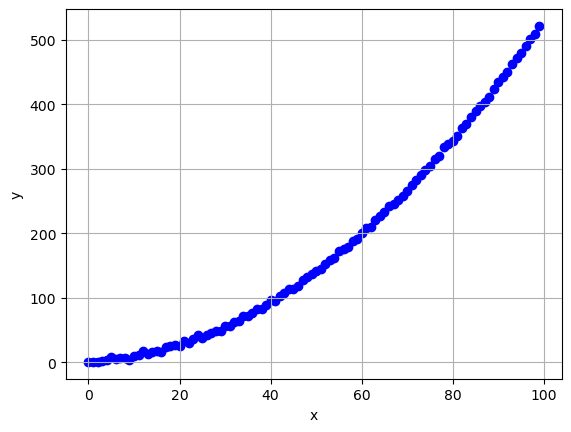

In [29]:
x = np.array(df.index)
y = np.array(df['Output (kW)'])

plt.scatter(x, y, color="b")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

---

## Python Function for Matrix Operation

### Matrix initialization

In [30]:
def pol_matrix (x, y, n):
    x_ = np.zeros((n, n))
    y_ = np.zeros((n, 1))

    for i in range(n):
        y_[i][0] = np.sum(y * x**i)
        for j in range(n):
            count = i + j
            if i + j == 0:
                x_[i][j] = len(x)
                continue
            x_[i][j] = np.sum(x**count)
    
    return x_, y_

### Matrix initialization for Gauss-Jordan

In [31]:
power = int(input("Enter the degree of the polynomial: "))
x_, y_ = pol_matrix(x, y, power+1)

gj_matrix = np.column_stack((x_, y_))

### Diagonal Dominant

In [32]:
def diagonal_dom(x):
    """
    Checks if the matrix is diagonal dominant.

    Parameters
    ----------
    x : numpy array
        The matrix to check.

    Returns
    -------
    bool
        True if the matrix is diagonal dominant, False otherwise.
    """
    n = x.shape[0]
    for i in range(n):
        sum = 0
        for j in range(n):
            if i != j:
                sum += abs(x[i, j])
        if abs(x[i, i]) <= sum:
            return False
    return True

---

## Matrix Operation

In [33]:
def lu_decomposition(X, y):

    n = X.shape[0]

    L = np.zeros((n, n))
    U = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            U[i][j] = X[i][j] - sum(L[i][k] * U[k][j] for k in range(i))

            L[i][i] = 1
            for j in range(i + 1, n):
                L[j][i] = (X[j][i] - sum(L[j][k] * U[k][i] for k in range(i))) / U[i][i]

    z = np.zeros(n)
    for i in range(n):
        z[i] = y[i] - sum(L[i][k] * z[k] for k in range(i))

    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (z[i] - sum(U[i][k] * x[k] for k in range(i + 1, n))) / U[i][i]

    return [x,0,0]

### Gauss-Jordan

In [34]:
def gauss_jordan(x):
    n = x.shape[0]

    for i in range(n):
        x[i] = x[i] / x[i][i]
        for j in range(n):
            if i != j:
                x[j] = x[j] - x[i] * x[j][i]

    return [x[:, -1],0,0]

### Jacobi Iteration

In [35]:
def round_nearest(value, nearest):
    """
    Rounds a given value to the nearest multiple of another value.

    Parameters
    ----------
    value : float
        The value to round.
    nearest : float
        The value to round to the nearest multiple of.

    Returns
    -------
    float
        The rounded value.
    """
    return np.ceil(value / nearest) * nearest

In [36]:
def jacobi_iteration(X, y, x_init=None, tol=1e-3, max_iter=1000):
    # if diagonal_dom(X) == False:
    #     return ["Matrix is not diagonal dominant"]

    n = len(y)

    if x_init is None:
        x_init = np.zeros(n)

    Diag = np.diag(X)
    R = X - np.diagflat(Diag)

    x_final = [x_init.tolist()]
    error = [np.inf]

    for iter in range(max_iter):
        x_new = (y - np.dot(R, x_init)) / Diag
        temp_err = abs(np.linalg.norm((x_new - x_init) / x_new, ord=np.inf))
        error.append(temp_err)
        x_final.append(x_new.tolist())
        if round_nearest(temp_err, tol) <= tol:
            return [x_final, error, iter + 1]

        x_init = x_new

    return [x_final, error, iter + 1]

### Gauss Seidel

In [37]:
def gauss_seidel(X, y, x_init=None, tol=1e-3, max_iter=1000):
    # if diagonal_dom(X) == False:
    #     return ['Matrix is not diagonal dominant']

    n = len(y)

    if x_init is None:
        x = np.zeros(n)
    else:
        x = x_init.copy()

    x_final = [x.tolist()]
    error = [np.inf]

    for k in range(max_iter):
        x_new = x.copy()

        for i in range(n):
            sum1 = np.dot(X[i, :i], x_new[:i])
            sum2 = np.dot(X[i, i + 1 :], x[i + 1 :])

            x_new[i] = (y[i] - sum1 - sum2) / X[i, i]

        temp_err = abs(np.linalg.norm((x_new - x) / x_new, ord=np.inf))

        error.append(temp_err)
        x_final.append(x_new.tolist())
        if round_nearest(temp_err, tol) <= tol:
            return [x_final, error, k + 1]

        x = x_new

    return [x, error, max_iter]

---

## Function to be Solved

In [38]:
# function to be solved in exponential regression
def exp_func(b):
    sum_yx_exp_bx = np.sum(y * x * np.exp(b * x))
    sum_y_exp_bx = np.sum(y * np.exp(b * x))
    sum_exp_2bx = np.sum(np.exp(2 * b * x))
    sum_x_exp_2bx = np.sum(x * np.exp(2 * b * x))

    second_term = (sum_y_exp_bx / sum_exp_2bx) * sum_x_exp_2bx

    result = sum_yx_exp_bx - second_term
    return result

In [39]:
def deriv_exp_func(b):
    sum_yx_exp_bx = np.sum(y * x * np.exp(b * x))
    sum_y_exp_bx = np.sum(y * np.exp(b * x))
    sum_exp_2bx = np.sum(np.exp(2 * b * x))
    sum_x_exp_2bx = np.sum(x * np.exp(2 * b * x))
    sum_x2_exp_2bx = np.sum(x**2 * np.exp(2 * b * x))
    sum_yx2_exp_bx = np.sum(y * x**2 * np.exp(b * x))


    second_term = (sum_yx_exp_bx*sum_x_exp_2bx + sum_y_exp_bx*2*sum_x2_exp_2bx)/(sum_exp_2bx*sum_x_exp_2bx)
    third_term = sum_y_exp_bx*sum_x_exp_2bx*2*sum_x_exp_2bx/(sum_exp_2bx)**2

    result = sum_yx2_exp_bx - second_term + third_term
    return result

---

## Exponential Method

### Newton-Raphson Method

In [40]:
def newtonRaphson(f, g, a, tol, N=100):

    # print(f"{'Iterasi':>8} | {'xi':>20} | {'xi+1':>20} | {'error':>20}")
    # print("-" * 80)
    step = 1
    flag = 1
    condition = True
    while condition:
        if g(a) == 0.0:
            # print("Divide by zero error!")
            break

        b = a - f(a) / g(a)
        error = abs(b - a) / abs(b)
        # print(f"{step:>8} | {a:>20} | {b:>20} | {error:>20}")
        a = b
        step = step + 1

        if step > N:
            flag = 0
            break

        condition = error > tol

    return b

### Modified Newton-Raphson Method

In [41]:
def mod_newtonRaphson(f, g, a, tol, N=100):
    # print(f"{'Iterasi':>8} | {'xi':>20} | {'xi+1':>20} | {'error':>20}")
    # print("-" * 80)
    step = 1
    flag = 1
    condition = True
    while condition:
        if g(a) == 0.0:
            # print("Divide by zero error!")
            break

        b = a - f(a) * g(a) / (g(a) ** 2 - f(a) * g(a))
        error = abs(b - a) / abs(b)
        # print(f"{step:>8} | {a:>20} | {b:>20} | {error:>20}")
        a = b
        step = step + 1

        if step > N:
            flag = 0
            break

        condition = error > tol

    return b

### Secant Method

In [42]:
def secant(f, a, b, e, N=100):
    print("\n-----Secant-----")
    print(f"{'Iterasi':>8} | {'xi-1':>20} | {'xi':>20} | {'xi+1':>20} | {'error':>20}")
    print("-" * 105)
    step = 1
    condition = True
    while condition:
        if f(a) == f(b):
            print("Divide by zero error!")
            break

        m = a - (b - a) * f(a) / (f(b) - f(a))
        error = abs(m - a) / abs(m)
        print(f"{step:>8} | {a:>20} | {m:>20} | {b:>20} | {error:>20}")
        a = b
        b = m
        step = step + 1

        if step > N:
            print("Not Convergent!")
            break

        condition = error > e
    return m

### Modified Secant

In [43]:
def mod_secant(f, a, delta, e, N=1000):
    print("\n-----Modified Secant-----")
    print(f"{'Iterasi':>8} | {'xi-1':>20} | {'xi+1':>20} | {'error':>20}")
    print("-" * 80)
    step = 1
    condition = True
    while condition:
        if f(a + delta) == f(a):
            print("Divide by zero error!")
            break

        m = a - delta * f(a) / (f(a + delta) - f(a))
        error = abs(m - a) / abs(m)
        print(f"{step:>8} | {a:>20} | {m:>20} | {error:>20}")
        a = m
        step = step + 1

        if step > N:
            print("Not Convergent!")
            break

        condition = error > e

    return m

## Linear Regression Function

In [44]:
def linear_regression(x, y):
    n = np.size(x)

    # Find the value of a_0 and a_1
    a_0 = (np.sum(x**2) * np.sum(y) - np.sum(x) * np.sum(x * y)) / (
        n * np.sum(x**2) - np.sum(x) ** 2
    )
    a_1 = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (
        n * np.sum(x**2) - np.sum(x) ** 2
    )

    # Find the value of y_hat or predicted y
    y_bar = np.mean(y)
    y_hat = a_0 + a_1 * x

    # Find the value of Sy, Syx, r2, and r
    Sy = np.sqrt(np.sum((y - y_bar) ** 2) / (n - 1))
    Syx = np.sqrt((np.sum((y - y_hat) ** 2)) / (n - 2))
    r2 = (Sy**2 - Syx**2) / Sy**2
    r = np.sqrt(r2)

    return [a_0, a_1], Sy, Syx, r2, r, y_hat

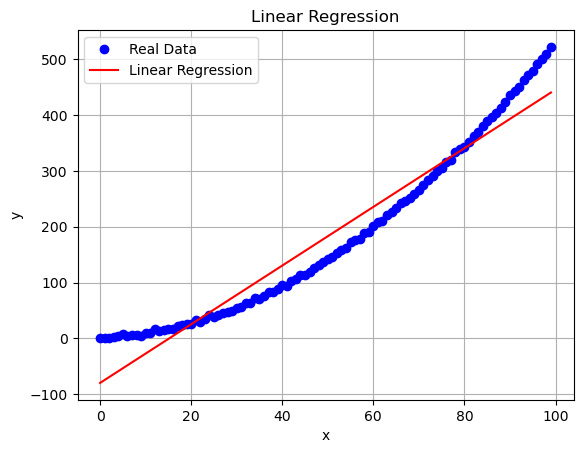

Intercept = -79.52356781459869
Slope = 5.249063437389669
Standard Deviation = 156.8069
Error = 37.5834
R^2 = 94.26%
R = 97.09%


In [45]:
linear_const, Sy, Syx, r2, r, y_hat = linear_regression(x, y)

plt.plot(x, y, "bo")
plt.plot(x, y_hat, "r")
plt.title("Linear Regression")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.legend(["Real Data", "Linear Regression"])

plt.show()

print(f"Intercept = {linear_const[0]}")
print(f"Slope = {linear_const[1]}")
print(f"Standard Deviation = {Sy:.4f}")
print(f"Error = {Syx:.4f}")
print(f"R^2 = {r2:.2%}")
print(f"R = {r:.2%}")

---

## Polynomial Regression Function

In [46]:
def polynomial_regression(x, y, coef, m):
    if type(coef) == str:
        print(coef)
        return np.zeros(m+1), 0, 0, 0, 0, np.zeros_like(y)

    n = x.shape[0]

    y_bar = np.mean(y)

    y_hat = 0

    for i in range(m+1):

        y_hat = y_hat + coef[i] * x**i

    Sy = np.sqrt(np.sum((y - y_bar) ** 2) / (n - 1))
    Syx = np.sqrt((np.sum((y - y_hat) ** 2)) / (n - m -1 ))
    r2 = (Sy**2 - Syx**2) / Sy**2
    r = np.sqrt(r2)

    return coef, Sy, Syx, r2, r, y_hat

In [47]:
list_func = [lu_decomposition(x_, y_), gauss_jordan(gj_matrix), gauss_seidel(x_, y_), jacobi_iteration(x_, y_)]

tittles = ["LU Decomposition", "Gauss-Jordan", "Gauss-Seidel", "Jacobi Iteration"]

results = []

for func in list_func:
    results.append(func[0])

C:\Users\M S I\AppData\Local\Temp\ipykernel_7860\535702092.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i] = y[i] - sum(L[i][k] * z[k] for k in range(i))
C:\Users\M S I\AppData\Local\Temp\ipykernel_7860\93141.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new[i] = (y[i] - sum1 - sum2) / X[i, i]
C:\Users\M S I\AppData\Local\Temp\ipykernel_7860\1783321822.py:18: RuntimeWarning: invalid value encountered in divide
  temp_err = abs(np.linalg.norm((x_new - x_init) / x_new, ord=np.inf))


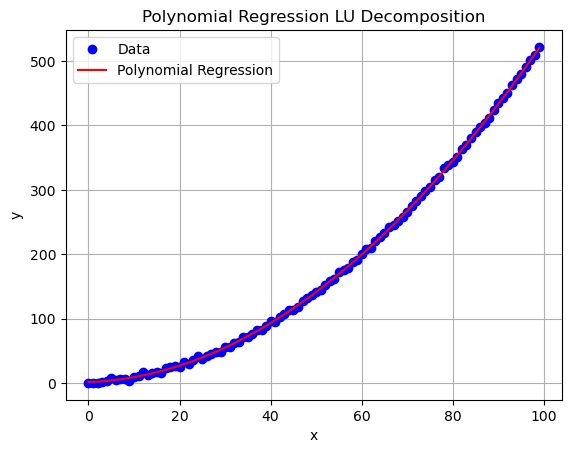

=====Polynomial Regression LU Decomposition=====
Coef = [ 1.59206402e+00  2.52330004e-01  5.13891580e-02 -1.02586559e-05]
Standard Deviation = 156.8069
Error = 1.9023
R^2 = 99.99%
R = 99.99%



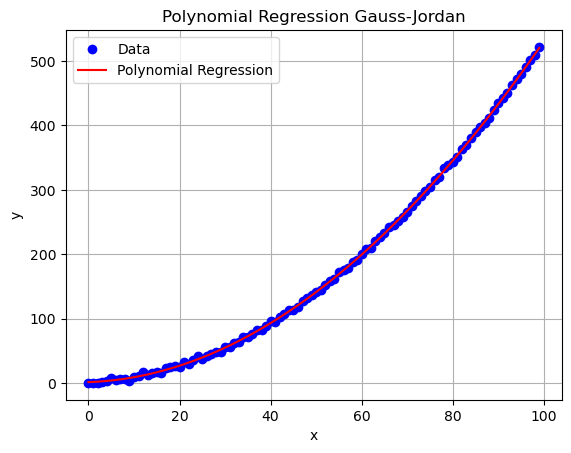

=====Polynomial Regression Gauss-Jordan=====
Coef = [ 1.59206402e+00  2.52330004e-01  5.13891580e-02 -1.02586559e-05]
Standard Deviation = 156.8069
Error = 1.9023
R^2 = 99.99%
R = 99.99%



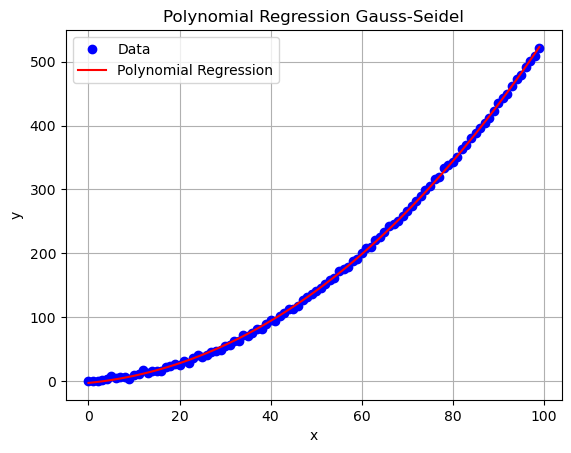

=====Polynomial Regression Gauss-Seidel=====
Coef = [-2.50056338e+00  7.05407808e-01  4.06173264e-02  5.92462132e-05]
Standard Deviation = 156.8069
Error = 2.3523
R^2 = 99.98%
R = 99.99%



ValueError: operands could not be broadcast together with shapes (4,) (100,) 

In [48]:
for idx, result in enumerate(results):
    tittle = tittles[idx]
    coef, Sy, Syx, r2, r, y_hat = polynomial_regression(x, y, result,  power)

    plt.plot(x, y, 'bo')
    plt.plot(x, y_hat, 'r')
    plt.title(f"Polynomial Regression {tittle}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Data', 'Polynomial Regression'])
    plt.grid()
    plt.show()

    print(f"{5*'='}Polynomial Regression {tittle}{5*'='}")
    print(f"Coef = {coef}")
    print(f"Standard Deviation = {Sy:.4f}")
    print(f"Error = {Syx:.4f}")
    print(f"R^2 = {r2:.2%}")
    print(f"R = {r:.2%}\n")

---

## Exponential Regression Function

In [24]:
def exp_regression(x, y, a_1):  # using modified secant method

    n = np.size(x)

    a_0 = np.sum(y * np.exp(a_1 * x)) / np.sum(np.exp(2 * a_1 * x))

    # Find the value of y_hat or predicted y
    y_bar = np.mean(y)
    y_hat = a_0 * np.exp(a_1 * x)

    # Find the value of Sy, Syx, r2, and r
    Sy = np.sqrt(np.sum((y - y_bar) ** 2) / (n - 1))
    Syx = np.sqrt((np.sum((y - y_hat) ** 2)) / (n - 2))
    r2 = (Sy**2 - Syx**2) / Sy**2
    r = np.sqrt(r2)

    return [a_0, a_1], Sy, Syx, r2, r, y_hat


-----Secant-----
 Iterasi |                 xi-1 |                   xi |                 xi+1 |                error
---------------------------------------------------------------------------------------------------------
       1 |                  0.1 |  0.09282677148741535 |                 0.11 |  0.07727542817275665
       2 |                 0.11 |  0.08788022766336731 |  0.09282677148741535 |  0.25170363032472287
       3 |  0.09282677148741535 |  0.07869219773652669 |  0.08788022766336731 |  0.17961849023728288
       4 |  0.08788022766336731 |  0.07122164566120666 |  0.07869219773652669 |  0.23389774060267646
       5 |  0.07869219773652669 |  0.06318967746673657 |  0.07122164566120666 |   0.2453331128007537
       6 |  0.07122164566120666 | 0.055577789564480576 |  0.06318967746673657 |  0.28147675931904953
       7 |  0.06318967746673657 |  0.04821720909616173 | 0.055577789564480576 |    0.310521256854883
       8 | 0.055577789564480576 |  0.04152894056946067 |  0.04821720

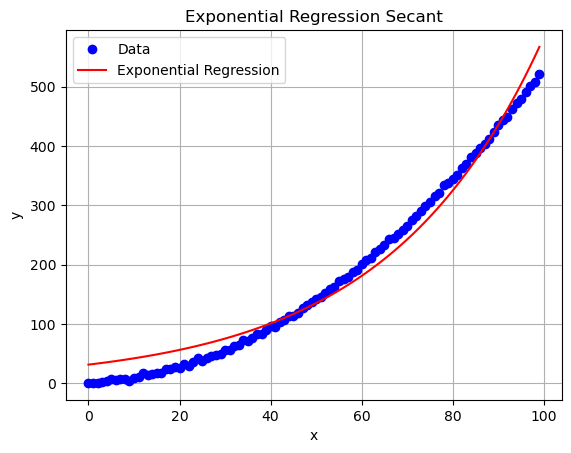

=====Exponential Regression Secant=====
Coef = [31.22454349420956, 0.02928386402520566]
Standard Deviation = 156.8069
Error = 22.7010
R^2 = 97.90%
R = 98.95%



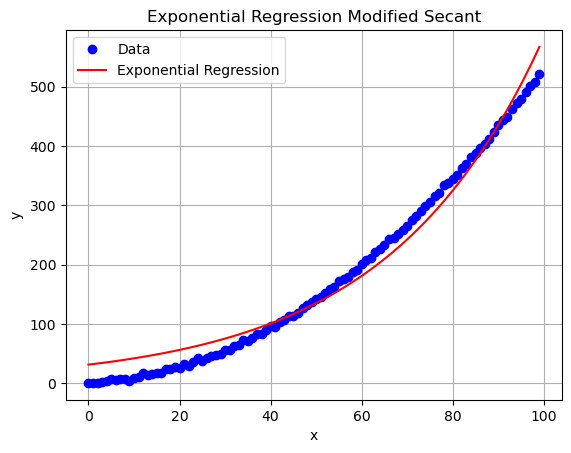

=====Exponential Regression Modified Secant=====
Coef = [31.20750054297644, 0.029290464980693695]
Standard Deviation = 156.8069
Error = 22.7010
R^2 = 97.90%
R = 98.95%



In [25]:
a1 = [secant(exp_func, 0.1, 0.11, 0.001), mod_secant(exp_func, 1, 0.01, 0.001)]

tittles = ["Secant", "Modified Secant"]

for idx, a in enumerate(a1):
    coef, Sy, Syx, r2, r, y_hat = exp_regression(x, y, a)

    plt.plot(x, y, 'bo')
    plt.plot(x, y_hat, 'r')

    plt.title(f"Exponential Regression {tittles[idx]}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(['Data', 'Exponential Regression'])
    plt.grid()
    plt.show()

    print(f"{5*'='}Exponential Regression {tittles[idx]}{5*'='}")
    print(f"Coef = {coef}")
    print(f"Standard Deviation = {Sy:.4f}")
    print(f"Error = {Syx:.4f}")
    print(f"R^2 = {r2:.2%}")
    print(f"R = {r:.2%}\n")

In [26]:
a = np.zeros(5)
a

array([0., 0., 0., 0., 0.])